# Household Power Consumption

## Jack Foley - C00274246

### Dataset Download and Setup

Please download the dataset from [here](https://archive.ics.uci.edu/dataset/235/individual+household+electric+power+consumption) and extract the .txt file into the `electricity_usage` folder (where `main.ipynb` is located).

### About the Dataset

This dataset has taken "measurements of electric power consumption in one household with a one-minute sampling rate over a period of almost 4 years."

The original format is in a `.txt` file, but should be easy enough to convert to something more workable like a `.csv` file.

The current headings are as follows:
1. date: Date in format dd/mm/yyyy
2. time: time in format hh:mm:ss
3. global_active_power: household global minute-averaged active power (in kilowatt)
4. global_reactive_power: household global minute-averaged reactive power (in kilowatt)
5. voltage: minute-averaged voltage (in volt)
6. global_intensity: household global minute-averaged current intensity (in ampere)
7. sub_metering_1: energy sub-metering No. 1 (in watt-hour of active energy). It corresponds to the kitchen, containing mainly a dishwasher, an oven and a microwave (hot plates are not electric but gas powered).
8. sub_metering_2: energy sub-metering No. 2 (in watt-hour of active energy). It corresponds to the laundry room, containing a washing-machine, a tumble-drier, a refrigerator and a light.
9. sub_metering_3: energy sub-metering No. 3 (in watt-hour of active energy). It corresponds to an electric water-heater and an air-conditioner.

I am not entirely sure what the difference between **active** and **reactive** power is, and I cannot seem to find any documentation about it from the dataset source.

It could be assumed that the true total electricity usage is as follows: 
> `total_consumption = global_active_power + sub_metering_1 + sub_metering_2 + sub_metering_3`

### What can we do with this data?

Looking at the dataset, we could make predictions about whether or not we can expect higher power consumpution at a certain date and time. For example, you would probably use more power at 5PM in January vs. 6AM in August. We could make a simple decision tree model to make these predictions.

In [9]:
import pandas as pd
import numpy as np

""" 

Here I am trying to load the data from the file 'household_power_consumption.txt' into a pandas dataframe.
Since it is a .txt file, I am using the read_csv method of pandas to read the file and specifying the separator as ';'. I also specify the na_values as ['?', ''] to replace the missing values with NaN.

"""

try:
    df = pd.read_csv('household_power_consumption.txt', sep=';', na_values=['?', ''])
    print("Successfully loaded the data into a pandas dataframe!")
except FileNotFoundError:
    print('File not found')
    exit()

Successfully loaded the data into a pandas dataframe!


That seems to have worked, now I want to convert all of the column headers to lowercase. 

Next Steps:
1. I want to convert the date and time columns into a datetime object and drop the original date and time columns.
2. Using this new datetime object, create the new `year`, `month`, `day`, `hour`, `day_of_week` and `quarter` features.
3. Create the `total_consumption` feature. 

In [10]:
# Convert all column headers to lowercase
df.columns = [col.lower() for col in df.columns]

# Convert date and time columns
df['date_time'] = pd.to_datetime(df['date'] + ' ' + df['time'], format='%d/%m/%Y %H:%M:%S', errors='coerce')

# Drop the original date and time columns
df = df.drop(['date', 'time'], axis=1)

# Handle missing values
df = df.replace({np.nan: 0})

# Creating new features from datetime object
df['year'] = df['date_time'].dt.year
df['month'] = df['date_time'].dt.month
df['day'] = df['date_time'].dt.day
df['hour'] = df['date_time'].dt.hour
df['day_of_week'] = df['date_time'].dt.dayofweek  # Monday=0, Sunday=6
df['quarter'] = df['date_time'].dt.quarter

# Calculate total consumption
df['total_consumption'] = df['global_active_power'] + df['sub_metering_1'] + df['sub_metering_2'] + df['sub_metering_3']

df.columns

Index(['global_active_power', 'global_reactive_power', 'voltage',
       'global_intensity', 'sub_metering_1', 'sub_metering_2',
       'sub_metering_3', 'date_time', 'year', 'month', 'day', 'hour',
       'day_of_week', 'quarter', 'total_consumption'],
      dtype='object')

The next step is to create the consumption categories of low, medium and high.

In [11]:
consumption_stats = df['total_consumption'].describe()
low_threshold = consumption_stats['25%']
high_threshold = consumption_stats['75%']

def categorize_consumption(consumption):
    if consumption < low_threshold:
        return 'low'
    elif consumption < high_threshold:
        return 'medium'
    else:
        return 'high'

df['consumption_category'] = df['total_consumption'].apply(categorize_consumption)

print(df.head())

   global_active_power  global_reactive_power  voltage  global_intensity  \
0                4.216                  0.418   234.84              18.4   
1                5.360                  0.436   233.63              23.0   
2                5.374                  0.498   233.29              23.0   
3                5.388                  0.502   233.74              23.0   
4                3.666                  0.528   235.68              15.8   

   sub_metering_1  sub_metering_2  sub_metering_3           date_time  year  \
0             0.0             1.0            17.0 2006-12-16 17:24:00  2006   
1             0.0             1.0            16.0 2006-12-16 17:25:00  2006   
2             0.0             2.0            17.0 2006-12-16 17:26:00  2006   
3             0.0             1.0            17.0 2006-12-16 17:27:00  2006   
4             0.0             1.0            17.0 2006-12-16 17:28:00  2006   

   month  day  hour  day_of_week  quarter  total_consumption  \
0   

Next I will create some visualisations using Seaborn and matplotlib.

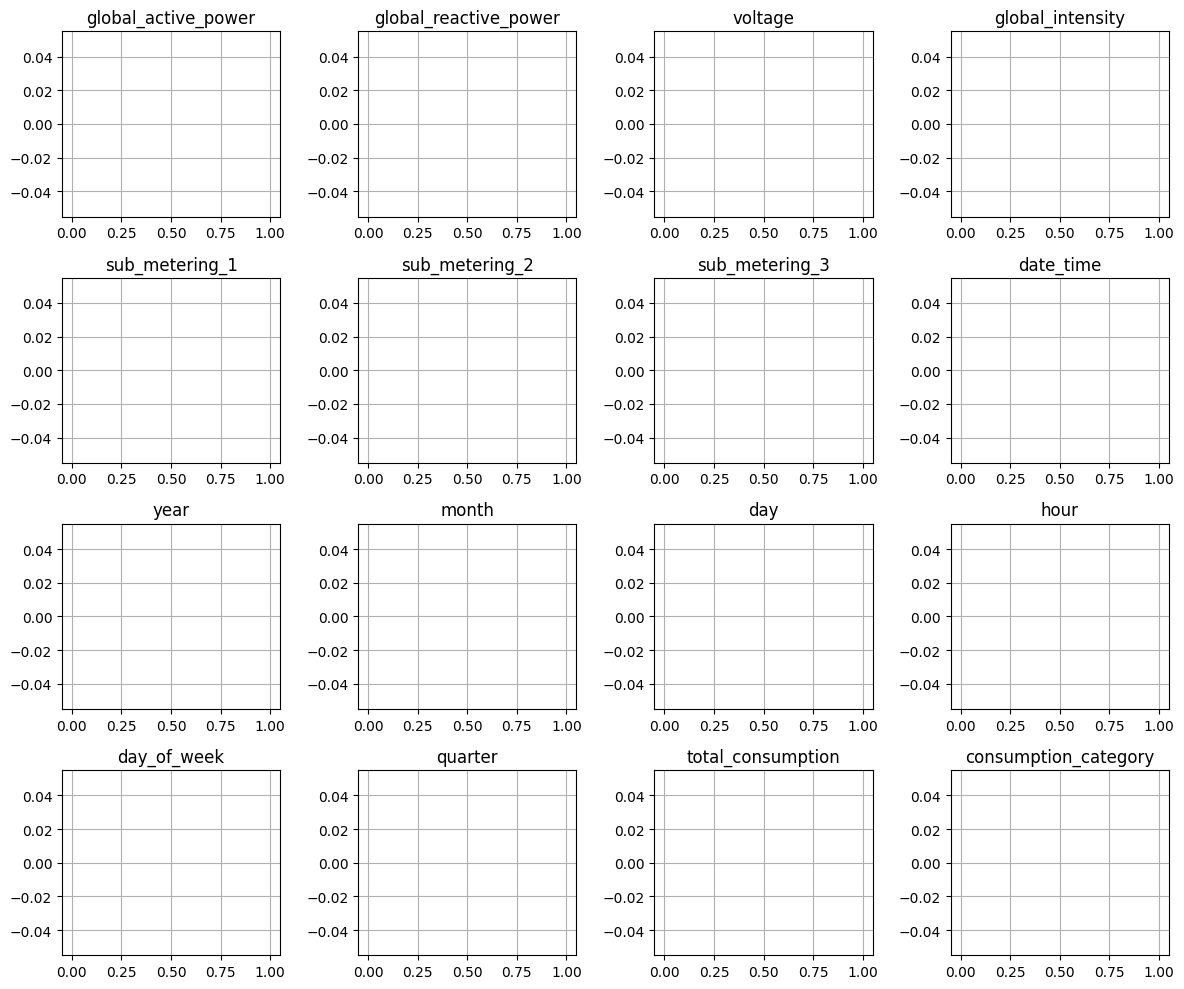

c:\Users\jackf\Documents\College\DataSciML\.venv\Lib\site-packages\seaborn\matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
c:\Users\jackf\Documents\College\DataSciML\.venv\Lib\site-packages\seaborn\matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


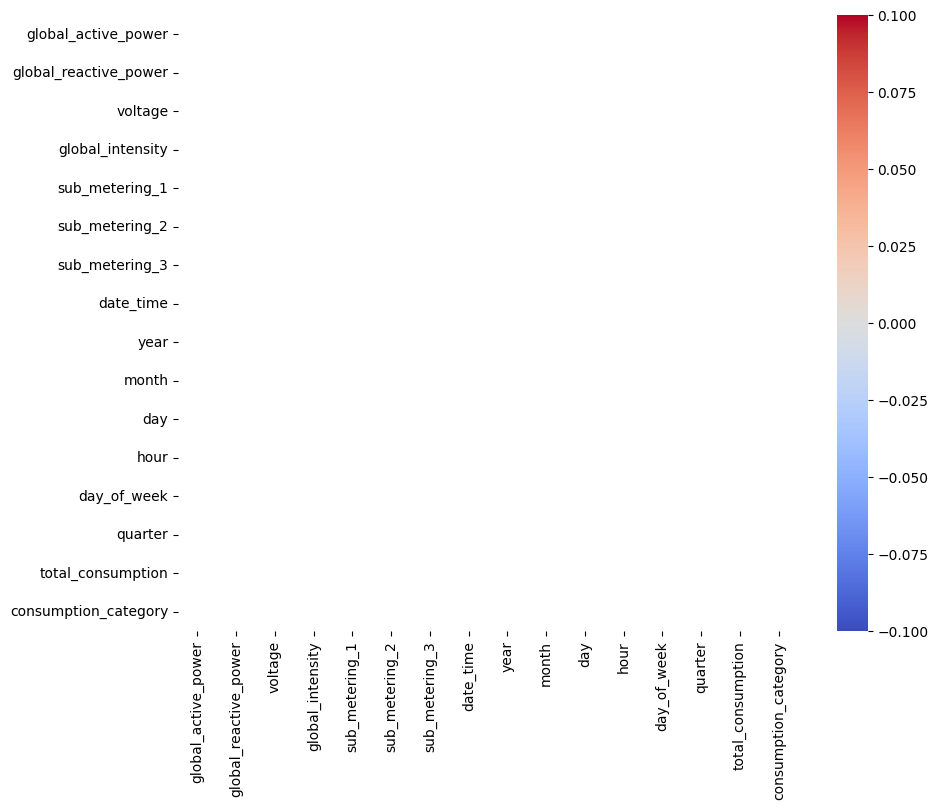

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

#Ensure all data is numeric
for col in df.columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')
df = df.dropna()

# Select only numeric columns, excluding 'date_time'
numeric_df = df.select_dtypes(include=['number'])

# Histograms for all numeric columns
numeric_df.hist(figsize=(12, 10))
plt.tight_layout()
plt.show()

# Correlation matrix for numeric columns
corr_matrix = numeric_df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()